# Q5. Find best genre based on worldwide gross.

In [1]:
# import statements
import pandas as pd
import numpy as np
import requests as rq
import sqlite3
from sklearn.preprocessing import OneHotEncoder
from zipfile import ZipFile
import tarfile
import gzip
import matplotlib.pyplot as plt

In [2]:
# IMDB Name Data    
with gzip.open("zippedData/imdb.name.basics.csv.gz", "rb") as f:
    imdb_name_basics = pd.read_csv(f)

with gzip.open("zippedData/imdb.title.akas.csv.gz", "rb") as f:
    imdb_title_akas = pd.read_csv(f)

with gzip.open("zippedData/imdb.title.basics.csv.gz", "rb") as f:
    imdb_title_basics = pd.read_csv(f)

with gzip.open("zippedData/imdb.title.crew.csv.gz", "rb") as f:
    imdb_title_crew = pd.read_csv(f)
    
with gzip.open("zippedData/imdb.title.principals.csv.gz", "rb") as f:
    imdb_title_principals = pd.read_csv(f)

with gzip.open("zippedData/imdb.title.ratings.csv.gz", "rb") as f:
    imdb_title_ratings = pd.read_csv(f)
    
# TN Movie Data
with gzip.open("zippedData/tn.movie_budgets.csv.gz", "rb") as f:
    tn_movie_budgets = pd.read_csv(f)

# Data Exploration

In [3]:
tn_movie_budgets.head(1)

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"


In [4]:
imdb_title_akas.head(1)

,title_id,ordering,title,region,language,types,attributes,is_original_title
0,tt0369610,10,Джурасик свят,BG,bg,NaN,NaN,0.0


In [5]:
imdb_title_basics.head(1)

,tconst,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama"


# Data Cleaning

In [6]:
# Select only movies from US region and change column 'title' to 'movie'
x_df = imdb_title_akas.loc[imdb_title_akas['region'] == 'US']
x_df = x_df.rename(columns={'title': 'movie'})

In [7]:
x_df.head(1)

,title_id,ordering,movie,region,language,types,attributes,is_original_title
12,tt0369610,21,Jurassic World 3D,US,NaN,NaN,3-D version,0.0


In [8]:
# Merge tn_movie_budgets and x_df on tn_movie_budgets DF
gross_df = pd.merge(tn_movie_budgets, x_df, how='left', on='movie')

In [9]:
gross_df.head(1)

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,title_id,ordering,region,language,types,attributes,is_original_title
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279",NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
# Clean and turn 'worldwide_gross' into float for accurate sorting
gross_df['worldwide_gross'] = gross_df['worldwide_gross'].str.replace(',', '')
gross_df['worldwide_gross'] = gross_df['worldwide_gross'].str.replace('$', '')
gross_df['worldwide_gross'] = gross_df['worldwide_gross'].astype(float)
gross_df1 = gross_df.sort_values('worldwide_gross', ascending=False)

In [11]:
# Clean and turn 'production_budget' into float for accurate sorting
gross_df['production_budget'] = gross_df['production_budget'].str.replace(',', '')
gross_df['production_budget'] = gross_df['production_budget'].str.replace('$', '')
gross_df1['production_budget'] = gross_df['production_budget'].astype(float)

In [12]:
# Clean unused columns
movie_df = gross_df1.drop(['id', 'ordering', 'region', 'language', 
                           'types', 'attributes', 'is_original_title'], axis=1)

In [13]:
# Drop all duplicate film entries
movie_df = movie_df.drop_duplicates()

In [14]:
movie_df.head(1)

,release_date,movie,production_budget,domestic_gross,worldwide_gross,title_id
0,"Dec 18, 2009",Avatar,425000000.0,"$760,507,625",2.776345e+09,NaN


In [15]:
imdb_title_basics.head(1)

,tconst,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama"


In [16]:
# Change 'primary_title' to 'movie'
imdb_title_basics = imdb_title_basics.rename(columns={'primary_title': 'movie'})

In [17]:
# Merge movie_df and imdb_title_basics on 'movie'
genere_df = pd.merge(movie_df, imdb_title_basics, how='left', on='movie')

In [18]:
# Drop NaNs from 'genres'
genere_df = genere_df.dropna(subset=['genres'])

In [19]:
# Create a new column to reflect total profit
genere_df['profit'] = genere_df['worldwide_gross'] - genere_df['production_budget']

In [20]:
genere_df.head(1)

,release_date,movie,production_budget,domestic_gross,worldwide_gross,title_id,tconst,original_title,start_year,runtime_minutes,genres,profit
0,"Dec 18, 2009",Avatar,425000000.0,"$760,507,625",2.776345e+09,NaN,tt1775309,Abatâ,2011.0,93.0,Horror,2.351345e+09


In [21]:
# Create list of items in 'generes' column
list_of_genres = []
for key, value in genere_df['genres'].items():
    list_of_genres.append(value)

In [22]:
list_of_genres[0:5]

['Horror',
 'Adventure',
 'Family',
 'Action,Adventure,Sci-Fi',
 'Action,Adventure,Sci-Fi']

In [23]:
# Split list of genre columns
list_of_genres_full = []
for x in list_of_genres:
    list_of_genres_full.append(str(x).split(','))

In [24]:
list_of_genres_full[0:5]

[['Horror'],
 ['Adventure'],
 ['Family'],
 ['Action', 'Adventure', 'Sci-Fi'],
 ['Action', 'Adventure', 'Sci-Fi']]

In [25]:
# Create list of individual genres
genre_list = []
for element in list_of_genres_full:
    for item in element:
        if item not in genre_list:
            genre_list.append(item)

In [26]:
print(genre_list)

['Horror', 'Adventure', 'Family', 'Action', 'Sci-Fi', 'Crime', 'Thriller', 'Drama', 'Sport', 'Fantasy', 'Romance', 'Animation', 'Comedy', 'Musical', 'Documentary', 'Biography', 'Music', 'History', 'Mystery', 'Western', 'War', 'News', 'Reality-TV']


In [27]:
# Create genre dictionary for gross with key 0
genre_dict_gross = { i : 0 for i in genre_list }

In [28]:
print(genre_dict_gross)

{'Horror': 0, 'Adventure': 0, 'Family': 0, 'Action': 0, 'Sci-Fi': 0, 'Crime': 0, 'Thriller': 0, 'Drama': 0, 'Sport': 0, 'Fantasy': 0, 'Romance': 0, 'Animation': 0, 'Comedy': 0, 'Musical': 0, 'Documentary': 0, 'Biography': 0, 'Music': 0, 'History': 0, 'Mystery': 0, 'Western': 0, 'War': 0, 'News': 0, 'Reality-TV': 0}


In [29]:
# Make genre dictionary key equal to total worldwide gross for each genre
for index, row in genere_df.iterrows():
    gross = row['worldwide_gross']
    list_g = row['genres'].split(',')
    for i in list_g:
        genre_dict_gross[i] += gross

In [30]:
print(genre_dict_gross)

{'Horror': 38354358106.0, 'Adventure': 157260197402.0, 'Family': 51897204624.0, 'Action': 142056063685.0, 'Sci-Fi': 57287725647.0, 'Crime': 33726234053.0, 'Thriller': 66868002199.0, 'Drama': 182209412385.0, 'Sport': 8559405290.0, 'Fantasy': 53524012785.0, 'Romance': 35082967734.0, 'Animation': 56987821436.0, 'Comedy': 105205531703.0, 'Musical': 11941698836.0, 'Documentary': 87960442916.0, 'Biography': 30308030313.0, 'Music': 7069301234.0, 'History': 17234734622.0, 'Mystery': 23387901261.0, 'Western': 1696227711.0, 'War': 6298524339.0, 'News': 879951568.0, 'Reality-TV': 0.0}


In [31]:
# Create genre dictionary for profit with key 0
genre_dict_profit = { i : 0 for i in genre_list }

In [32]:
# Make genre dictionary key equal to total profit for each genre
for index, row in genere_df.iterrows():
    profit = row['profit']
    list_g = row['genres'].split(',')
    for i in list_g:
        genre_dict_profit[i] += profit

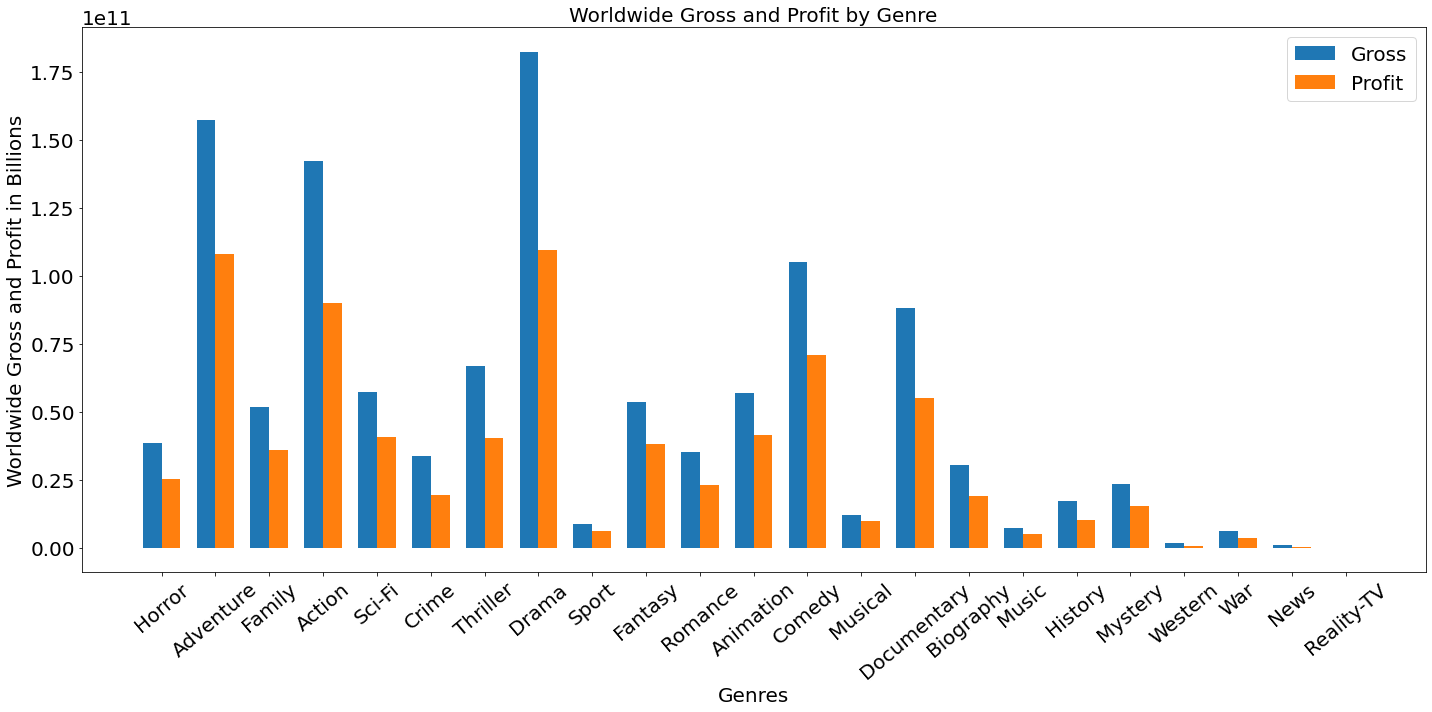

In [35]:
# Draw a visualization of the data
fig, ax = plt.subplots(figsize=(20,10))

labels = genre_list
width = 0.35

x = np.arange(len(labels))
#x  = genre_dict_gross.keys()
y1 = genre_dict_gross.values()
y2 = genre_dict_profit.values()

rects1 = ax.bar(x- width/2, y1, width, label='Gross')
rects2 = ax.bar(x+ width/2, y2, width, label='Profit')

ax.set_xticks(x)
ax.set_xticklabels(labels)
plt.rc('xtick', labelsize=20) 
plt.xticks(rotation=40)
plt.rc('ytick', labelsize=20)
ax.set_xlabel('Genres', fontsize=20)
ax.set_ylabel('Worldwide Gross and Profit in Billions', fontsize=20)
ax.set_title('Worldwide Gross and Profit by Genre', fontsize=20)
ax.legend(loc=1, prop={'size': 20})

#def autolabel(rects):
#    """Attach a text label above each bar in *rects*, displaying its height."""
#    for rect in rects:
#        height = rect.get_height()
#        ax.annotate('{}'.format(height),
#                    xy=(rect.get_x() + rect.get_width() / 2, height),
#                    xytext=(0, 3),  # 3 points vertical offset
#                    textcoords="offset points",
#                    ha='center', va='bottom')

#autolabel(rects1)
#autolabel(rects2)       
        
fig.tight_layout()
plt.show()